In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd

%matplotlib notebook

def exp_chirp(duration=2, sr=2**14, f0=110, gamma=0.5):
    t = torch.arange(0, duration, 1/sr)
    phi = f0 / (gamma*np.log(2)) * (2 ** (gamma*t) - 1)
    return torch.sin(2*np.pi*phi)


def generate(f_c, f_m, gamma=0.5, duration=2, sr=2**14):
    x_c = exp_chirp(duration=duration, sr=sr, gamma=gamma, f0=f_c) # carrier chirp
#     x_m = torch.cos(2 * np.pi * f_m * t)
    x = x_c * torch.hann_window(duration * sr)
    return x

def plot(x, sr=2**14):
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    librosa.display.waveshow(x.numpy(), sr=sr, ax=axes[0])
    axes[0].set_title("Waveplot of the signal")
    hop_length=256
    C = librosa.cqt(
        x.numpy(),
        fmin=55, bins_per_octave=12, n_bins=72, sr=sr, hop_length=hop_length)
    librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(C)),
        x_axis="time", sr=sr, hop_length=hop_length,
        y_axis="cqt_hz", bins_per_octave=12,
        ax=axes[1])
    axes[1].set_title("Time-Frequency Spectrogram of the signal")
    fig.tight_layout()
    
def disp_audio(x, rate=2**14):
    return ipd.Audio(x, rate=rate, autoplay=True)

<IPython.core.display.Javascript object>


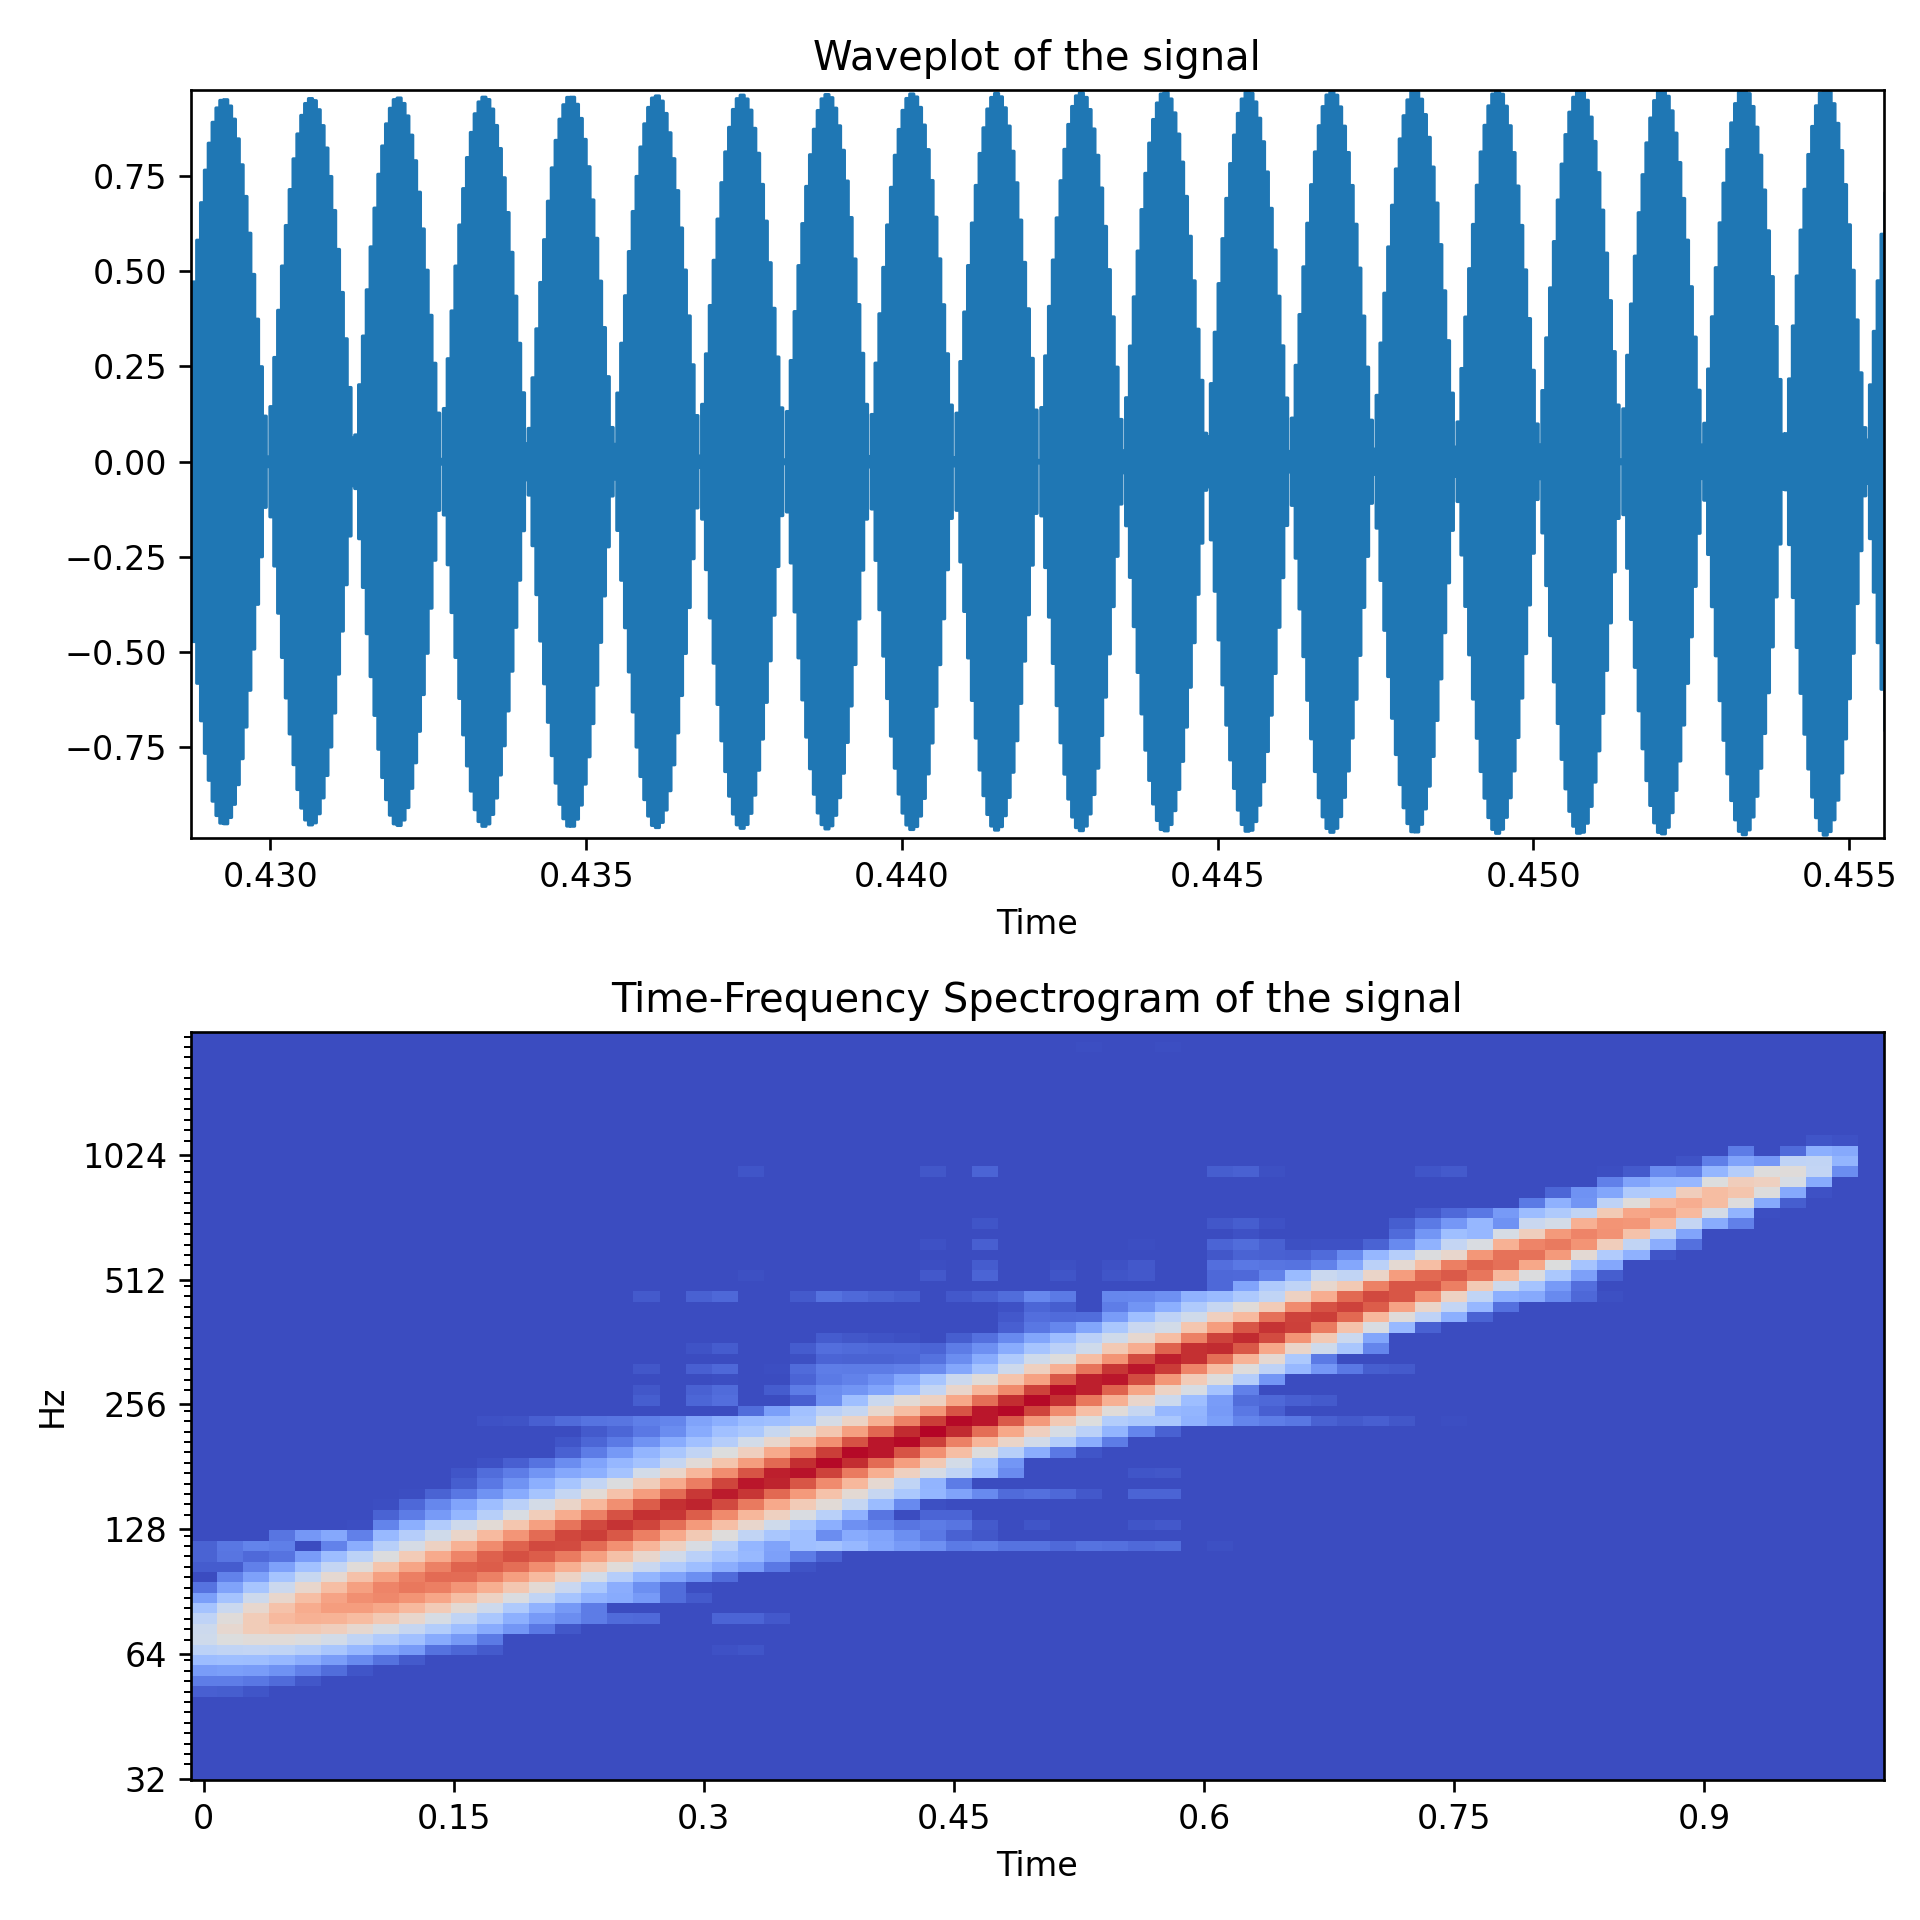

In [32]:
x = generate(f_c=110, f_m=2, gamma=4, duration=1, sr=2**14)
plot(x)
disp_audio(x)

In [ ]:
np.linspace(10, 20, 10)

In [ ]:
import tqdm

f0s = np.linspace(10, 20, 10)
fms = np.linspace(0, 5, 10)
rates = np.linspace(2, 5, 10)

audio = torch.zeros(len(f0s), len(fms), len(rates), N)
cmap = torch.zeros(3, len(f0s) * len(fms) * len(rates))
c = 0
for i, f0 in tqdm.tqdm(enumerate(f0s)):
    for j, fm in enumerate(fcs):
        for k, r in enumerate(rates):
            audio[i, j, k] = generate(f0, fm, r)
            cmap[0, c], cmap[1, c], cmap[2, c] = f0, fm, r
            c += 1
            
X = audio.view(-1, N)

In [144]:
from kymatio.torch import TimeFrequencyScattering1D

jtfs = TimeFrequencyScattering1D(
    shape=(N, ),
    T=N,
    Q=12,
    J=8,
    max_pad_factor=1, 
    max_pad_factor_fr=1)
jtfs(X).shape

torch.Size([1200, 5759, 1])

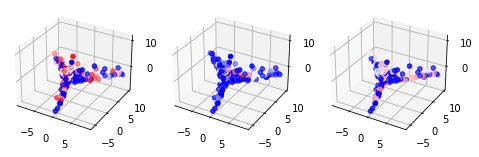

In [145]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=3, n_neighbors=40)
Y = embedding.fit_transform(X)

# f carrier
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[0], cmap='bwr');

# f modulator
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[1], cmap='bwr');

# chirp rate
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], c=cmap[2], cmap='bwr');